# **Overfitting**

In the last notebook, you have implemented a CNN model for the Fashion MNIST dataset, by adding more layers and parameters, you should see improvement in the training set accuracy. But can your model generalize well to unseen data? Do you see degrade in the testing set accuracy when adding more parameters? This is a phenomenon called **overfitting**.

\
In this notebook, you will experiment with different techniques (i.e. regularization and dropout) to deal with overfitting.
You are going to compare the ***underfitted model***, ***overfitted model*** and the ***regularized model*** with the ***baseline model***.

\
**Instruction: type your code when you see 'Type your code here' in comments**

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Tensorflow version:',tf.__version__)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
from sklearn.model_selection import train_test_split 
import os
print('Keras version:', tf.keras.__version__)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

Num GPUs Available:  1
Tensorflow version: 2.6.0
Keras version: 2.6.0


# Loading the fashion_mnist data set training set

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
print(f'Shape of an image: {x_train[0].shape}')
print(f'Max pixel value: {x_train.max()}')
print(f'Min pixel value: {x_train.min()}')
print(f'Classes: {np.unique(y_train)}')

Shape of an image: (28, 28)
Max pixel value: 255
Min pixel value: 0
Classes: [0 1 2 3 4 5 6 7 8 9]


In [4]:
# Creating a list of labels

fashion_mnist_labels = ["T-shirt/top", 
                            "Trouser",
                            "Pullover",
                            "Dress",
                            "Coat",
                            "Sandal", 
                            "Shirt",
                            "Sneaker",
                            "Bag",
                            "Ankle boot"]

# Plotting some of the images

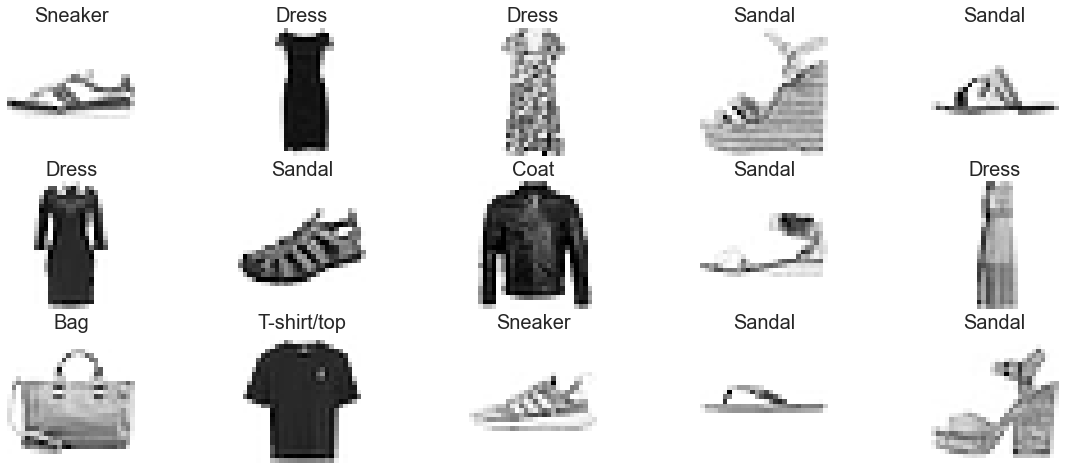

In [5]:
figure = plt.figure(figsize=(20,8))

indices = np.random.choice(np.arange(x_train.shape[0]), 15, replace=False)
subset = x_train[indices]

for i, image_sample in enumerate(subset):
  ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
  j = fashion_mnist_labels[y_train[indices[i]]] #image label
  ax.set_title(j, fontsize=20)
  ax.imshow(image_sample.reshape(28,28))
  i+=1

In [6]:
x_train = x_train/255
x_test = x_test/255

num_classes = 10

train_one_hot = tf.keras.utils.to_categorical(y_train,num_classes)
test_one_hot = tf.keras.utils.to_categorical(y_test,num_classes)

print(y_train[0])
print(train_one_hot[0])

train_size = x_train.shape[0]
test_size = x_test.shape[0]


print(f'Max pixel value: {x_train.max()}')
print(f'Min pixel value: {x_train.min()}')
print(f'Train size: {train_size}, Test size: {test_size}')
print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')
print(f'Train label shape: {train_one_hot.shape}, Test label shape: {test_one_hot.shape}')


9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Max pixel value: 1.0
Min pixel value: 0.0
Train size: 60000, Test size: 10000
Train data shape: (60000, 28, 28), Test data shape: (10000, 28, 28)
Train label shape: (60000, 10), Test label shape: (10000, 10)


# **Model training**

In [7]:
batch_size = 100
epoch = 2000


es = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=40,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)


## **Baseline model**

In [8]:
BASELINE_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+BASELINE_INPUT_SHAPE)
x_test = x_test.reshape([-1]+BASELINE_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

Train data shape: (60000, 28, 28, 1), Test data shape: (10000, 28, 28, 1)


In [9]:
tf.keras.backend.clear_session()

inputs = Input(shape=BASELINE_INPUT_SHAPE)

x = Conv2D(filters=10, kernel_size=(4,4), strides=(1,1),
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(50, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

baseline_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="baseline_model")

baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 10)        170       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                98050     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 98,730
Trainable params: 98,730
Non-trainable params: 0
________________________________________________

In [10]:
baseline_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


baseline_hist = baseline_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

Epoch 1/2000
420/420 [==============================] - 5s 5ms/step - loss: 0.5849 - accuracy: 0.7983 - val_loss: 0.4407 - val_accuracy: 0.8456
Epoch 2/2000
420/420 [==============================] - 2s 4ms/step - loss: 0.4055 - accuracy: 0.8597 - val_loss: 0.3796 - val_accuracy: 0.8667
Epoch 3/2000
420/420 [==============================] - 2s 4ms/step - loss: 0.3549 - accuracy: 0.8741 - val_loss: 0.3465 - val_accuracy: 0.8791
Epoch 4/2000
420/420 [==============================] - 2s 4ms/step - loss: 0.3219 - accuracy: 0.8856 - val_loss: 0.3196 - val_accuracy: 0.8866
Epoch 5/2000
420/420 [==============================] - 2s 4ms/step - loss: 0.3002 - accuracy: 0.8920 - val_loss: 0.3081 - val_accuracy: 0.8907
Epoch 6/2000
420/420 [==============================] - 2s 4ms/step - loss: 0.2802 - accuracy: 0.9000 - val_loss: 0.3125 - val_accuracy: 0.8889
Epoch 7/2000
420/420 [==============================] - 2s 4ms/step - loss: 0.2644 - accuracy: 0.9048 - val_loss: 0.2854 - val_accuracy:

## **Underfitted model**

In [11]:
UNDERFIT_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+UNDERFIT_INPUT_SHAPE)
x_test = x_test.reshape([-1]+UNDERFIT_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

Train data shape: (60000, 28, 28, 1), Test data shape: (10000, 28, 28, 1)


In [12]:
tf.keras.backend.clear_session()


inputs = Input(shape=UNDERFIT_INPUT_SHAPE)

x = Conv2D(filters=1, kernel_size=(4,4), strides=(1,1),
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(5, activation='relu')(x) 

outputs = Dense(num_classes, activation='softmax')(x)

underfitted_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="underfitted_model")


underfitted_model.summary()

Model: "underfitted_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 1)         17        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 196)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 985       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_______________________________________________

In [13]:
underfitted_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


underfitted_hist = underfitted_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

Epoch 1/2000
420/420 [==============================] - 2s 4ms/step - loss: 1.2198 - accuracy: 0.5365 - val_loss: 0.9423 - val_accuracy: 0.6411
Epoch 2/2000
420/420 [==============================] - 1s 3ms/step - loss: 0.8690 - accuracy: 0.6660 - val_loss: 0.8230 - val_accuracy: 0.6853
Epoch 3/2000
420/420 [==============================] - 1s 3ms/step - loss: 0.7846 - accuracy: 0.6995 - val_loss: 0.7674 - val_accuracy: 0.7173
Epoch 4/2000
420/420 [==============================] - 1s 3ms/step - loss: 0.7359 - accuracy: 0.7220 - val_loss: 0.7326 - val_accuracy: 0.7292
Epoch 5/2000
420/420 [==============================] - 1s 3ms/step - loss: 0.7057 - accuracy: 0.7344 - val_loss: 0.7020 - val_accuracy: 0.7391
Epoch 6/2000
420/420 [==============================] - 1s 3ms/step - loss: 0.6857 - accuracy: 0.7415 - val_loss: 0.6888 - val_accuracy: 0.7390
Epoch 7/2000
420/420 [==============================] - 1s 3ms/step - loss: 0.6721 - accuracy: 0.7456 - val_loss: 0.6789 - val_accuracy:

## **Overfitted model**

In [14]:
OVERFIT_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+OVERFIT_INPUT_SHAPE)
x_test = x_test.reshape([-1]+OVERFIT_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

Train data shape: (60000, 28, 28, 1), Test data shape: (10000, 28, 28, 1)


In [15]:
tf.keras.backend.clear_session()



inputs = Input(shape=OVERFIT_INPUT_SHAPE)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1),
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu')(x)
                    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu')(x)
                    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(1000, activation='relu')(x)

x = Dense(64, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

overfitted_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="overfitted_model")

overfitted_model.summary()


Model: "overfitted_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)     

In [16]:
overfitted_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

overfitted_hist = overfitted_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

Epoch 1/2000
420/420 [==============================] - 4s 7ms/step - loss: 0.5952 - accuracy: 0.7745 - val_loss: 0.4201 - val_accuracy: 0.8461
Epoch 2/2000
420/420 [==============================] - 3s 7ms/step - loss: 0.3596 - accuracy: 0.8671 - val_loss: 0.3652 - val_accuracy: 0.8626
Epoch 3/2000
420/420 [==============================] - 3s 7ms/step - loss: 0.3062 - accuracy: 0.8854 - val_loss: 0.3040 - val_accuracy: 0.8886
Epoch 4/2000
420/420 [==============================] - 3s 7ms/step - loss: 0.2768 - accuracy: 0.8973 - val_loss: 0.3082 - val_accuracy: 0.8883
Epoch 5/2000
420/420 [==============================] - 3s 7ms/step - loss: 0.2558 - accuracy: 0.9052 - val_loss: 0.2818 - val_accuracy: 0.8978
Epoch 6/2000
420/420 [==============================] - 3s 7ms/step - loss: 0.2391 - accuracy: 0.9105 - val_loss: 0.2848 - val_accuracy: 0.8981
Epoch 7/2000
420/420 [==============================] - 3s 7ms/step - loss: 0.2253 - accuracy: 0.9153 - val_loss: 0.2751 - val_accuracy:

# Regularized model

## Open question(Task):

This regularized model has the same architecture as the overfitted model, please add some dropout layers after the Conv2D/Dense layers and regularizations in the Conv2D/Dense layers, see what is the best testing set accuracy you can achieve

\

**Links to the documentation for your reference:**

Dropout:
https://keras.io/api/layers/regularization_layers/dropout/

L1/L2 regularization:
https://keras.io/api/layers/regularizers/








In [17]:
REGULARIZED_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+REGULARIZED_INPUT_SHAPE)
x_test = x_test.reshape([-1]+REGULARIZED_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

Train data shape: (60000, 28, 28, 1), Test data shape: (10000, 28, 28, 1)


In [18]:
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()


#Type your code here

inputs = Input(shape=REGULARIZED_INPUT_SHAPE)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), 
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Dropout(0.2)(x)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu')(x)
                    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Dropout(0.2)(x)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu')(x)
                    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)


x = Flatten()(x)

x = Dropout(0.2)(x)

x = Dense(1000, activation='relu',kernel_regularizer = regularizers.l2(0.1))(x)

x = Dropout(0.2)(x)

x = Dense(64, activation='relu',kernel_regularizer = regularizers.l2(0.1))(x)

outputs = Dense(num_classes, activation='softmax')(x)

regularized_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="regularized_model")


regularized_model.summary()


Model: "regularized_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)    

In [19]:
regularized_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

regularized_hist = regularized_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

Epoch 1/2000
420/420 [==============================] - 4s 9ms/step - loss: 1.3545 - accuracy: 0.6715 - val_loss: 0.6827 - val_accuracy: 0.7808
Epoch 2/2000
420/420 [==============================] - 3s 8ms/step - loss: 0.7056 - accuracy: 0.7808 - val_loss: 0.5913 - val_accuracy: 0.8124
Epoch 3/2000
420/420 [==============================] - 3s 8ms/step - loss: 0.6294 - accuracy: 0.8057 - val_loss: 0.5479 - val_accuracy: 0.8346
Epoch 4/2000
420/420 [==============================] - 3s 8ms/step - loss: 0.5871 - accuracy: 0.8197 - val_loss: 0.5165 - val_accuracy: 0.8371
Epoch 5/2000
420/420 [==============================] - 3s 8ms/step - loss: 0.5571 - accuracy: 0.8280 - val_loss: 0.4905 - val_accuracy: 0.8488
Epoch 6/2000
420/420 [==============================] - 3s 8ms/step - loss: 0.5345 - accuracy: 0.8344 - val_loss: 0.4792 - val_accuracy: 0.8533
Epoch 7/2000
420/420 [==============================] - 4s 8ms/step - loss: 0.5170 - accuracy: 0.8413 - val_loss: 0.4449 - val_accuracy:

# **Plotting the learning curves**

In [20]:
baseline_hist_df = pd.DataFrame(baseline_hist.history)
columns = {'loss':'Baseline train loss','accuracy':'Baseline train acc','val_loss':'Baseline val loss','val_accuracy':'Baseline val acc'}
baseline_hist_df.rename(columns=columns, inplace=True)


In [21]:
underfitted_hist_df = pd.DataFrame(underfitted_hist.history)
columns = {'loss':'Underfit train loss','accuracy':'Underfit train acc','val_loss':'Underfit val loss','val_accuracy':'Underfit val acc'}
underfitted_hist_df.rename(columns=columns, inplace=True)


In [22]:
overfitted_hist_df = pd.DataFrame(overfitted_hist.history)
columns = {'loss':'Overfit train loss','accuracy':'Overfit train acc','val_loss':'Overfit val loss','val_accuracy':'Overfit val acc'}
overfitted_hist_df.rename(columns=columns, inplace=True)


In [23]:
regularized_hist_df = pd.DataFrame(regularized_hist.history)
columns = {'loss':'Regularized train loss','accuracy':'Regularized train acc','val_loss':'Regularized val loss','val_accuracy':'Regularized val acc'}
regularized_hist_df.rename(columns=columns, inplace=True)


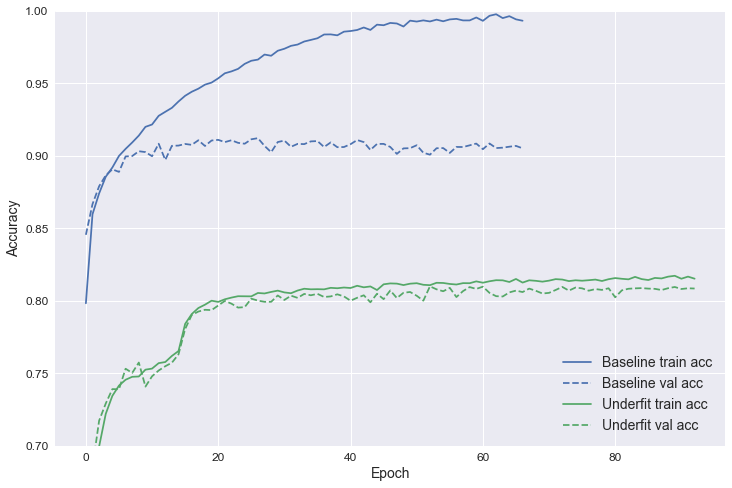

In [24]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')

plt.plot(underfitted_hist_df['Underfit train acc'], color='C1', linestyle='-',label='Underfit train acc')
plt.plot(underfitted_hist_df['Underfit val acc'], color='C1', linestyle='--',label='Underfit val acc')

plt.ylim([0.7,1])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)

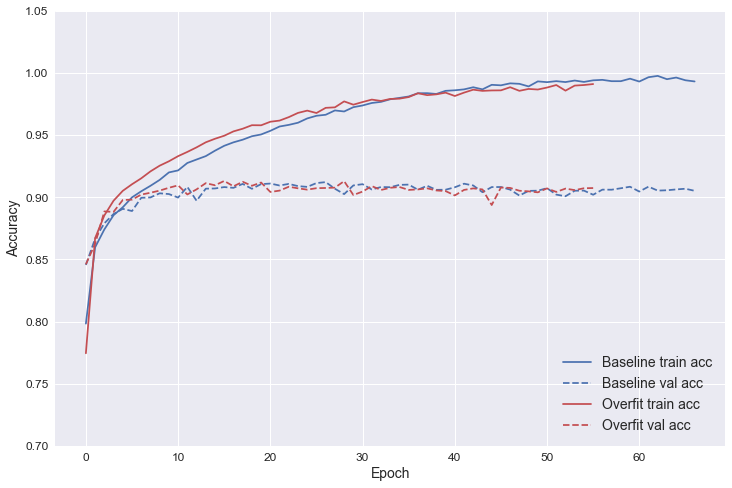

In [25]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')

plt.plot(overfitted_hist_df['Overfit train acc'], color='C2', linestyle='-',label='Overfit train acc')
plt.plot(overfitted_hist_df['Overfit val acc'], color='C2', linestyle='--',label='Overfit val acc')

plt.ylim([0.7,1.05])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)


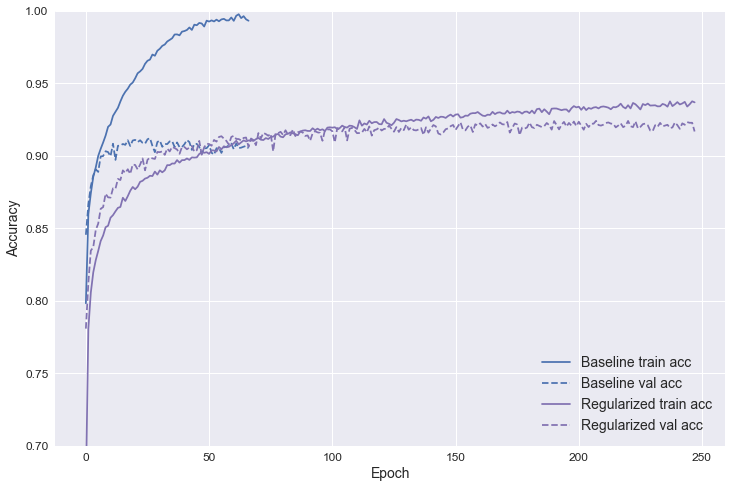

In [26]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')


plt.plot(regularized_hist_df['Regularized train acc'], color='C3', linestyle='-',label='Regularized train acc')
plt.plot(regularized_hist_df['Regularized val acc'], color='C3', linestyle='--',label='Regularized val acc')

plt.ylim([0.7,1.])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)


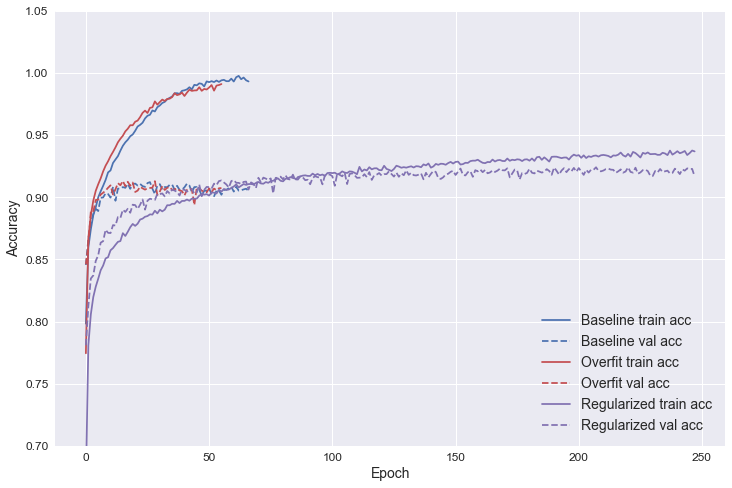

In [27]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')

plt.plot(overfitted_hist_df['Overfit train acc'], color='C2', linestyle='-',label='Overfit train acc')
plt.plot(overfitted_hist_df['Overfit val acc'], color='C2', linestyle='--',label='Overfit val acc')

plt.plot(regularized_hist_df['Regularized train acc'], color='C3', linestyle='-',label='Regularized train acc')
plt.plot(regularized_hist_df['Regularized val acc'], color='C3', linestyle='--',label='Regularized val acc')

plt.ylim([0.7,1.05])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)


# **Model evaluation on test set**

In [28]:
scores = baseline_model.evaluate(x_test.reshape([-1]+BASELINE_INPUT_SHAPE), test_one_hot, verbose=1)
names = baseline_model.metrics_names

for i in range(len(scores)):
  print(f'Baseline model test {names[i]}: {scores[i]:.4f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.3317 - accuracy: 0.9020
Baseline model test loss: 0.3317
Baseline model test accuracy: 0.9020


In [29]:
scores = underfitted_model.evaluate(x_test.reshape([-1]+UNDERFIT_INPUT_SHAPE), test_one_hot, verbose=1)
names = underfitted_model.metrics_names

for i in range(len(scores)):
  print(f'Underfitted model test {names[i]}: {scores[i]:.4f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.5842 - accuracy: 0.7997
Underfitted model test loss: 0.5842
Underfitted model test accuracy: 0.7997


In [30]:
scores = overfitted_model.evaluate(x_test.reshape([-1]+OVERFIT_INPUT_SHAPE), test_one_hot, verbose=1)
names = overfitted_model.metrics_names

for i in range(len(scores)):
  print(f'Overfitted model test {names[i]}: {scores[i]:.4f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.2939 - accuracy: 0.9065
Overfitted model test loss: 0.2939
Overfitted model test accuracy: 0.9065


In [31]:
scores = regularized_model.evaluate(x_test.reshape([-1]+REGULARIZED_INPUT_SHAPE), test_one_hot, verbose=1)
names = regularized_model.metrics_names

for i in range(len(scores)):
  print(f'Regularized model test {names[i]}: {scores[i]:.4f}')

313/313 [==============================] - 1s 4ms/step - loss: 0.2918 - accuracy: 0.9171
Regularized model test loss: 0.2918
Regularized model test accuracy: 0.9171


# Making predictions and plotting the result

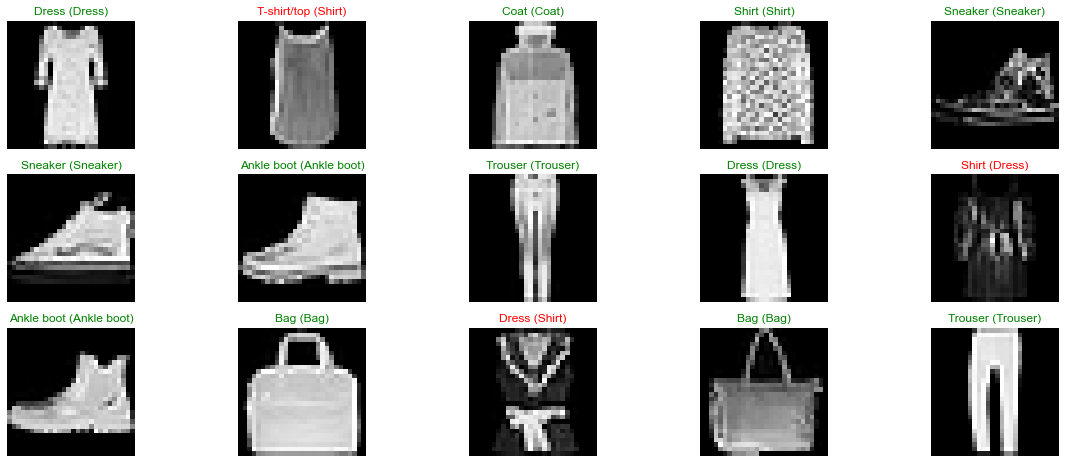

In [32]:
prediction = regularized_model.predict(x_test)


figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
   
    ax.imshow(x_test[index].reshape(28,28), cmap='gray')
    predict_index = np.argmax(prediction[index])
    true_index = np.argmax(test_one_hot[index])
   
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))